# Pipeline benchmarks

## Setup

In [1]:
from pathlib import Path
from typing import Optional

import janitor  # noqa: F401
import pandas as pd
import seaborn as sns

from speclet.io import project_root

In [2]:
%config InlineBackend.figure_format='retina'

In [3]:
benchmark_dir = project_root() / "benchmarks"
assert benchmark_dir.exists()
assert benchmark_dir.is_dir()

## Data Processing

Organization of benchmarks directory:

1. pipeline
2. rules
3. individual runs

> I may want to add more information to the name of the rules to keep them separate and not overwritten.
> For instance, including the date would be useful or metadata such as the data size for SBC or debug status for the fitting pipeline.

In [4]:
list(benchmark_dir.iterdir())

[PosixPath('/n/data1/hms/dbmi/park/Cook/speclet/benchmarks/010_010_run-crc-sampling-snakemake'),
 PosixPath('/n/data1/hms/dbmi/park/Cook/speclet/benchmarks/010_010_model-fitting-pipeline'),
 PosixPath('/n/data1/hms/dbmi/park/Cook/speclet/benchmarks/012_010_simulation-based-calibration-snakemake')]

In [5]:
def process_benchmark_file(bench_f: Path) -> pd.DataFrame:
    return pd.read_csv(bench_f, sep="\t").assign(
        step=bench_f.name.replace(bench_f.suffix, "")
    )


def get_benchmark_data_for_rule_dir(
    rule_d: Path, pipeline_name: str
) -> Optional[pd.DataFrame]:
    bench_dfs: list[pd.DataFrame] = [
        process_benchmark_file(b) for b in rule_d.iterdir()
    ]
    if len(bench_dfs) == 0:
        return None

    return (
        pd.concat(bench_dfs)
        .assign(rule=rule_d.name, pipeline=pipeline_name)
        .clean_names()
    )


benchmark_df_list: list[pd.DataFrame] = []

for pipeline_dir in benchmark_dir.iterdir():
    if pipeline_dir.name in {".DS_Store"}:
        continue
    for rule_dir in pipeline_dir.iterdir():
        df = get_benchmark_data_for_rule_dir(rule_dir, pipeline_name=pipeline_dir.name)
        if df is not None:
            benchmark_df_list.append(df)

benchmark_df = pd.concat(benchmark_df_list).reset_index(drop=True)
benchmark_df.head()

,s,h_m_s,max_rss,max_vms,max_uss,max_pss,io_in,io_out,mean_load,cpu_time,step,rule,pipeline
0,221.5452,0:03:41,1419.73,2140.38,1417.16,1417.25,908.23,16.45,17.16,38.26,simple-default_chain0,sample_mcmc,010_010_run-crc-sampling-snakemake
1,321.1937,0:05:21,465.15,1062.94,462.39,462.47,289.45,104.28,63.86,205.30,nine-noncentered_chain2,sample_mcmc,010_010_run-crc-sampling-snakemake
2,313.5864,0:05:13,407.55,1052.50,365.42,385.26,158.54,77.25,58.78,174.10,nine-noncentered_chain1,sample_mcmc,010_010_run-crc-sampling-snakemake
3,319.5655,0:05:19,423.44,1051.12,378.94,387.15,97.58,124.66,60.99,197.01,nine-default_chain1,sample_mcmc,010_010_run-crc-sampling-snakemake
4,224.0925,0:03:44,1419.79,2140.32,1417.19,1417.29,959.60,12.40,17.09,38.29,simple-default_chain1,sample_mcmc,010_010_run-crc-sampling-snakemake


## Data dictionary

| colname | type (unit) | description |
|-------- |-------------|-------------|
| s | float (seconds) | Running time in seconds. |
| h:m:s	| string (-) | Running time in hour, minutes, seconds format. |
| max_rss | float (MB) | Maximum "Resident Set Size”, this is the non-swapped physical memory a process has used. |
| max_vms | float (MB) | Maximum “Virtual Memory Size”, this is the total amount of virtual memory used by the process. |
| max_uss | float (MB) | “Unique Set Size”, this is the memory which is unique to a process and which would be freed if the process was terminated right now. |
| max_pss | float (MB) | “Proportional Set Size”, is the amount of memory shared with other processes, accounted in a way that the amount is divided evenly between the processes that share it (Linux only). |
| io_in | float (MB) | The number of MB read (cumulative). |
| io_out | float (MB) | The number of MB written (cumulative). |
| mean_load | float (-) | CPU usage over time, divided by the total running time (first row). |
| cpu_time | float (-) | CPU time summed for user and system. |

## Data analysis and visualization

In [6]:
benchmark_df.groupby(["pipeline", "rule"]).mean().round(2)

s  \
pipeline                                       rule                           
010_010_model-fitting-pipeline                 sample_pymc3_advi     273.26   
                                               sample_pymc3_mcmc     228.63   
                                               sample_stan_mcmc       47.53   
010_010_run-crc-sampling-snakemake             sample_advi           220.61   
                                               sample_mcmc          1419.45   
012_010_simulation-based-calibration-snakemake collate_sbc           641.62   
                                               generate_mockdata      20.44   
                                               run_sbc               602.97   
                                               sbc_uniformity_test   858.15   

                                                                    max_rss  \
pipeline                                       rule                           
010_010_model-fitting-pipeline                 sample_pymc3_advi     334.38   
                                               sample_pymc3_mcmc     385.99   
                                               sample_stan_mcmc      806.60   
010_010_run-crc-sampling-snakemake             sample_advi          1418.07   
                                               sample_mcmc           725.94   
012_010_simulation-based-calibration-snakemake collate_sbc           803.26   
                                               generate_mockdata     173.16   
                                               run_sbc              1744.51   
                                               sbc_uniformity_test  5310.08   

                                                                    max_vms  \
pipeline                                       rule                           
010_010_model-fitting-pipeline                 sample_pymc3_advi     945.97   
                                               sample_pymc3_mcmc     979.62   
                                               sample_stan_mcmc     2187.02   
010_010_run-crc-sampling-snakemake             sample_advi          2197.32   
                                               sample_mcmc          1345.14   
012_010_simulation-based-calibration-snakemake collate_sbc          2913.11   
                                               generate_mockdata     880.76   
                                               run_sbc              3399.60   
                                               sbc_uniformity_test  6813.24   

                                                                    max_uss  \
pipeline                                       rule                           
010_010_model-fitting-pipeline                 sample_pymc3_advi     287.92   
                                               sample_pymc3_mcmc     340.08   
                                               sample_stan_mcmc      602.32   
010_010_run-crc-sampling-snakemake             sample_advi          1415.48   
                                               sample_mcmc           708.15   
012_010_simulation-based-calibration-snakemake collate_sbc           799.93   
                                               generate_mockdata     170.72   
                                               run_sbc               742.90   
                                               sbc_uniformity_test  5305.28   

                                                                    max_pss  \
pipeline                                       rule                           
010_010_model-fitting-pipeline                 sample_pymc3_advi     309.51   
                                               sample_pymc3_mcmc     361.68   
                                               sample_stan_mcmc      704.21   
010_010_run-crc-sampling-snakemake             sample_advi          1415.64   
                                               sample_mcmc           711.92   
012_010_simulation-based-calibration-snak

In [7]:
benchmark_df_long = (
    benchmark_df[
        ["pipeline", "rule", "step", "cpu_time", "max_rss", "mean_load", "cpu_time"]
    ]
    .pivot_longer(["pipeline", "rule", "step"])
    .query("value != '-'")
    .astype({"value": float})
)

benchmark_df_long.head()

,pipeline,rule,step,variable,value
0,010_010_run-crc-sampling-snakemake,sample_mcmc,simple-default_chain0,cpu_time,38.26
1,010_010_run-crc-sampling-snakemake,sample_mcmc,nine-noncentered_chain2,cpu_time,205.30
2,010_010_run-crc-sampling-snakemake,sample_mcmc,nine-noncentered_chain1,cpu_time,174.10
3,010_010_run-crc-sampling-snakemake,sample_mcmc,nine-default_chain1,cpu_time,197.01
4,010_010_run-crc-sampling-snakemake,sample_mcmc,simple-default_chain1,cpu_time,38.29


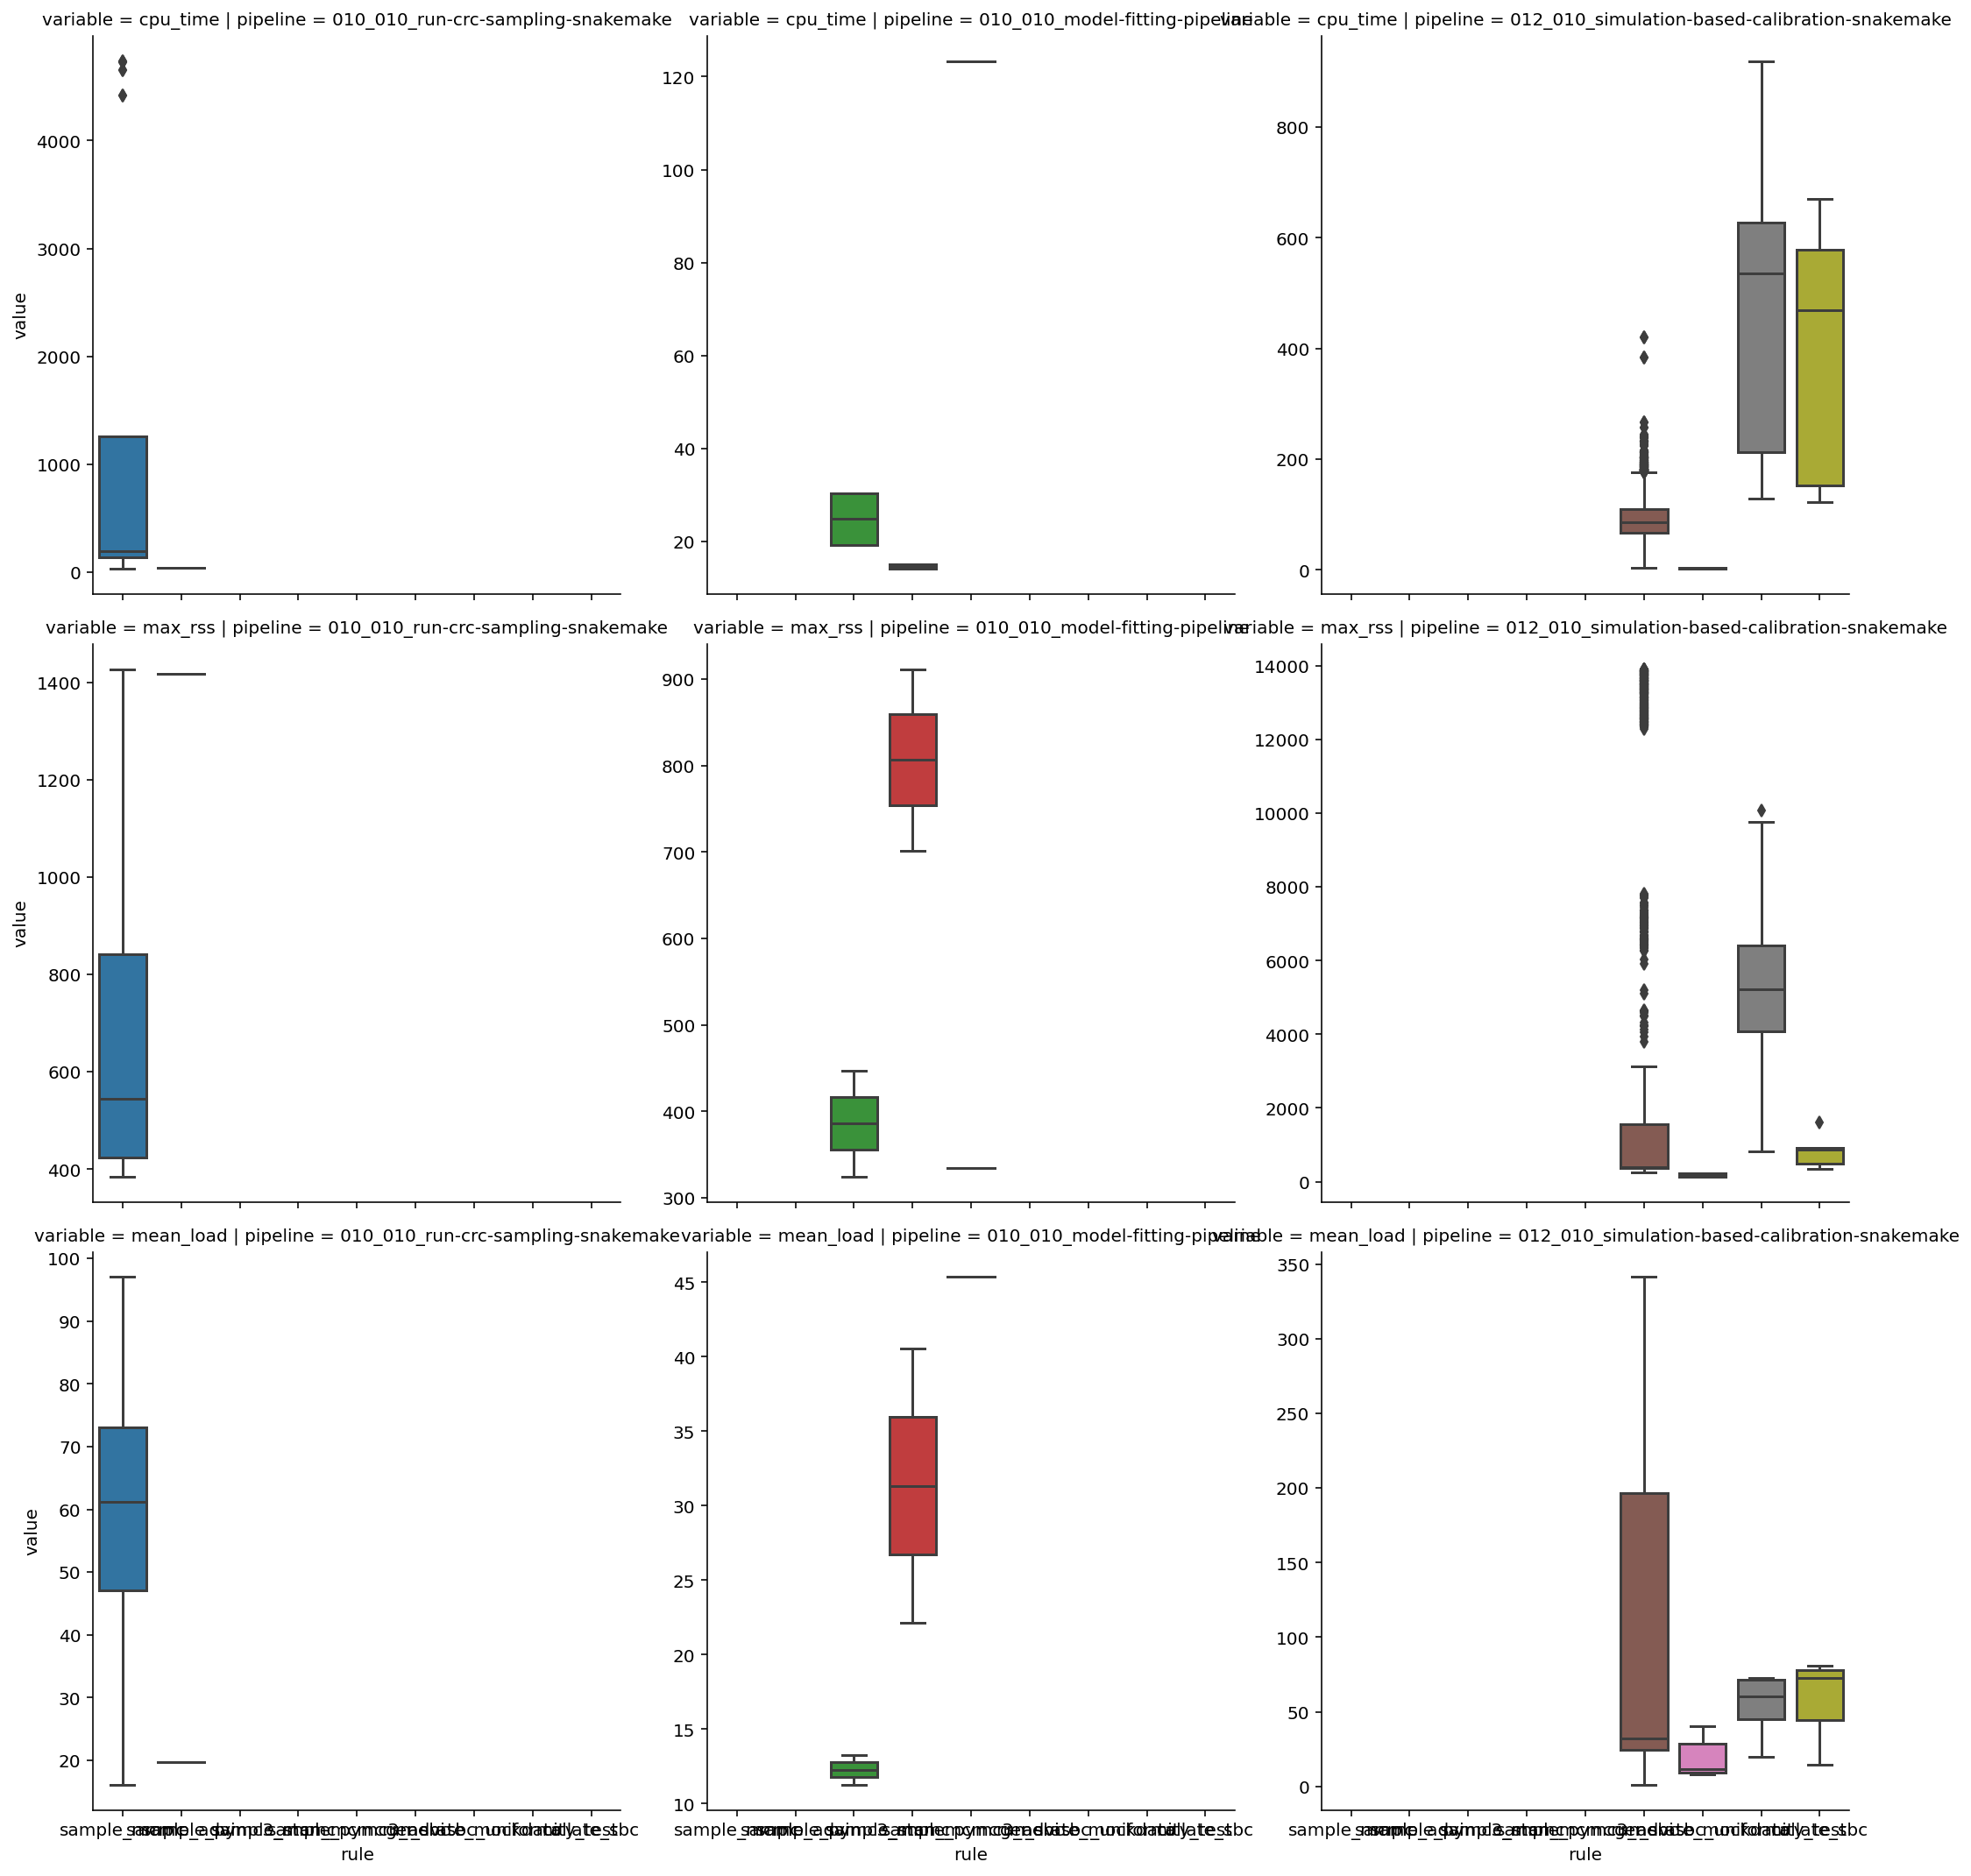

In [8]:
sns.catplot(
    data=benchmark_df_long,
    x="rule",
    y="value",
    kind="box",
    row="variable",
    col="pipeline",
    sharey=False,
)

---

In [9]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-01-18

Python implementation: CPython
Python version       : 3.9.9
IPython version      : 8.0.0

Compiler    : GCC 9.4.0
OS          : Linux
Release     : 3.10.0-1160.45.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 28
Architecture: 64bit

Hostname: compute-e-16-237.o2.rc.hms.harvard.edu

Git branch: run-on-o2

janitor: 0.22.0
seaborn: 0.11.2
pandas : 1.3.5

